<a href="https://colab.research.google.com/github/Harshanand7/GNR_602/blob/main/GNR602_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
crawford_deepsat_sat4_path = kagglehub.dataset_download('crawford/deepsat-sat4')

print('Data source import complete.')


100%|██████████| 2.98G/2.98G [00:26<00:00, 119MB/s]

Extracting files...


Data source import complete.


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from skimage.feature import hog, local_binary_pattern
from sklearn.preprocessing import StandardScaler
import cupy as cp
from cuml.svm import SVC, LinearSVC
from cuml.model_selection import train_test_split
import time
import ipywidgets as widgets  # This line imports the ipywidgets library and makes it accessible using the alias "widgets".
import numpy as np
from IPython.display import display
from skimage.io import imread
from skimage import color, transform
from skimage.feature import hog, local_binary_pattern
import cv2
from cuml.svm import SVC, LinearSVC
import cupy as cp
from cuml.svm import SVC, LinearSVC # This ensures that the SVC class is imported and available in the current scope.
import joblib
from cuml.svm import SVC, LinearSVC # This ensures that the SVC class is imported and available in the current scope.
import joblib
import matplotlib.pyplot as plt

In [3]:
import os

# Check the path
print("Dataset path:", crawford_deepsat_sat4_path)

# List all files and folders in the dataset path
print("Files:", os.listdir(crawford_deepsat_sat4_path))


Dataset path: /root/.cache/kagglehub/datasets/crawford/deepsat-sat4/versions/2
Files: ['X_train_sat4.csv', 'y_train_sat4.csv', 'sat-4-full.mat', 'X_test_sat4.csv', 'sat4annotations.csv', 'y_test_sat4.csv']


In [4]:
x_train_set_fpath = os.path.join(crawford_deepsat_sat4_path, 'X_test_sat4.csv')
y_train_set_fpath = os.path.join(crawford_deepsat_sat4_path, 'y_test_sat4.csv')


In [5]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # visualize satellite images
from skimage.io import imshow  # visualize satellite images
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout  # components of network
from keras.models import Sequential  # type of model

# Load your data


print('Loading Training Data')
X_train = pd.read_csv(x_train_set_fpath)
print('Loaded 28 x 28 x 4 images')

Y_train = pd.read_csv(y_train_set_fpath)
print('Loaded labels')




print('We have', X_train.shape[0], 'examples and each example is a list of', X_train.shape[1], 'numbers with', Y_train.shape[1], 'possible classifications.')

# Reshape the images to 28x28x4
X_train_img = X_train.values.reshape([99999, 28, 28, 4]).astype(float)
print(X_train_img.shape)


Loading Training Data
Loaded 28 x 28 x 4 images
Loaded labels
We have 99999 examples and each example is a list of 3136 numbers with 4 possible classifications.
(99999, 28, 28, 4)


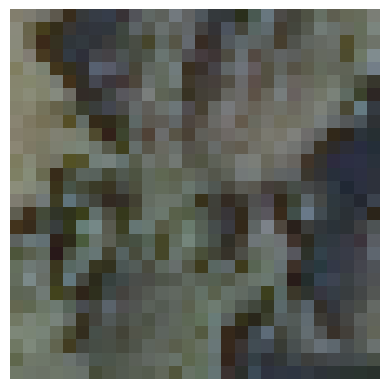

Trees


In [6]:
import matplotlib.pyplot as plt
from skimage import color
from skimage.feature import hog

# Visualizing one image
ix = 200  # Type a number between 0 and 99,999 inclusive

# Ensure the image is in a format that imshow can handle
img = np.squeeze(X_train_img[ix, :, :, 0:3])  # Only RGB channels
img = img / 255.0  # Ensure values are between 0 and 1 for proper display

# Check if the image is in the correct format for plotting
if img.shape[-1] == 3:  # Check if the image has 3 channels (RGB)
    plt.imshow(img.astype(float))  # Cast the image to float for display
    plt.axis('off')  # Optional: Hide axes for better visibility
    plt.show()
else:
    print("Image format is incorrect. It may not have 3 channels.")

# Tells what the image is
if Y_train.iloc[ix, 0] == 1:  # Use .iloc to access elements by integer index
    print('Barren Land')
elif Y_train.iloc[ix, 1] == 1:
    print('Trees')
elif Y_train.iloc[ix, 2] == 1:
    print('Grassland')
else:
    print('Other')


# Feature Extraction

In [7]:
from skimage import color
from skimage.feature import hog

hog_features_map = []
for i in range(99999):
    image_sample = np.squeeze(X_train_img[i, :, :, 0:3])
    image_gray = color.rgb2gray(image_sample)
    feature= hog(image_gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
    hog_features_map.append(feature)

from sklearn.preprocessing import MinMaxScaler

# Convert HOG feature map to a numpy array
hog_features_map = np.array(hog_features_map)

# Initialize a MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler and transform the features
hog_features_normalized = scaler.fit_transform(hog_features_map)

In [8]:
from skimage.feature import local_binary_pattern

lbp_features_map = []

for i in range(99999):
    image_sample = np.squeeze(X_train_img[i, :, :, 0:3])
    image_gray = color.rgb2gray(image_sample)

    # Extract LBP image
    lbp_img = local_binary_pattern(image_gray, P=8, R=1, method='uniform')

    # Histogram with 59 bins for 'uniform' patterns
    hist, _ = np.histogram(lbp_img.ravel(), bins=np.arange(0, 60), range=(0, 59))

    # Normalize histogram
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)

    # Append to list
    lbp_features_map.append(hist)


/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [9]:
import numpy as np
import cv2

def extract_gabor_features(img):
    # Define Gabor kernels (different orientations and scales)
    kernels = []
    for theta in np.arange(0, np.pi, np.pi / 4):  # 4 orientations
        for lamda in [2, 4]:  # 2 wavelengths
            kernels.append(cv2.getGaborKernel((21, 21), 5.0, theta, lamda, 1.0, 0, ktype=cv2.CV_32F))

    gabor_features = []
    for kernel in kernels:
        filtered_img = cv2.filter2D(img, cv2.CV_32F, kernel)
        gabor_features.append(filtered_img.mean())

    return np.array(gabor_features)

gabor_features_map = []
for i in range(99999):
    img = np.squeeze(X_train_img[i, :, :, 0:3])
    # Convert image to uint8 before color conversion
    img = img.astype(np.uint8)
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    gabor_features = extract_gabor_features(img_gray)
    gabor_features_map.append(gabor_features)

gabor_features_map = np.array(gabor_features_map)

In [10]:
from skimage import color
import cv2

def extract_color_histogram(img, bins=16):
    # Convert image to HSV color space
    # Convert image to uint8 before color conversion
    img = img.astype(np.uint8)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # Extract histograms for Hue, Saturation, and Value channels
    hist_hue = cv2.calcHist([img_hsv], [0], None, [bins], [0, 256])
    hist_saturation = cv2.calcHist([img_hsv], [1], None, [bins], [0, 256])
    hist_value = cv2.calcHist([img_hsv], [2], None, [bins], [0, 256])

    # Normalize histograms
    hist_hue = hist_hue / hist_hue.sum()
    hist_saturation = hist_saturation / hist_saturation.sum()
    hist_value = hist_value / hist_value.sum()

    # Concatenate histograms into a single feature vector
    return np.concatenate([hist_hue.flatten(), hist_saturation.flatten(), hist_value.flatten()])

color_histograms = []
for i in range(99999):
    img = np.squeeze(X_train_img[i, :, :, 0:3])
    color_hist = extract_color_histogram(img)
    color_histograms.append(color_hist)

color_histograms = np.array(color_histograms)

In [11]:
combined_features_handcrafted = np.concatenate((hog_features_map, lbp_features_map), axis=1)


In [12]:
combined_features_handcrafted_1 = np.concatenate((combined_features_handcrafted, color_histograms, gabor_features_map), axis=1)
combined_features = combined_features_handcrafted_1

# Converting into GPU Arrays

In [13]:

# Convert to GPU arrays (if you want to use cuML)
import cupy as cp
X_train_f_gpu = cp.asarray(combined_features)
Y_train_gpu = cp.asarray(Y_train)

# Check the shape of the combined features
print('Shape of combined features:', combined_features.shape)

# Train-test split on GPU
from cuml.model_selection import train_test_split
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_train_f_gpu, Y_train_gpu, test_size=0.2, random_state=42)

# Convert labels to single class (0, 1, 2, 3) for multi-class classification
y_train_f = cp.argmax(y_train_f, axis=1)
y_test_f = cp.argmax(y_test_f, axis=1)


Shape of combined features: (99999, 259)


# Training One vs One Model

In [14]:
# Train One-vs-One SVM using cuML
from cuml.svm import SVC
from sklearn.metrics import accuracy_score # Import accuracy_score
from sklearn.metrics import classification_report # Import classification report

# One-vs-One
svm_ovo = SVC(kernel='linear')  # Removed decision_function_shape
ts_ovo_train_start=time.time()
svm_ovo.fit(X_train_f, y_train_f)
ts_ovo_train_end=time.time()

y_pred_ovo = svm_ovo.predict(X_test_f)
ovo_accuracy = accuracy_score(y_test_f.get(), y_pred_ovo.get()) # Use .get() to convert to numpy array if needed
print("OvO Accuracy:", ovo_accuracy)

[2025-04-27 21:28:00.891] [CUML] [warning] SVC with the linear kernel can be much faster using the specialized solver provided by LinearSVC. Consider switching to LinearSVC if tranining takes too long.
OvO Accuracy: 0.9508475423771189


In [17]:
print("Training Time for OVO:",ts_ovo_train_end-ts_ovo_train_start,"s")

Training Time for OVO: 797.8553941249847 s


In [18]:
print(classification_report(y_test_f.get(), y_pred_ovo.get()))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      5153
           1       0.95      0.96      0.95      4021
           2       0.89      0.87      0.88      3624
           3       0.97      0.98      0.97      7201

    accuracy                           0.95     19999
   macro avg       0.94      0.94      0.94     19999
weighted avg       0.95      0.95      0.95     19999



# Training One vs Rest Model

In [19]:
from cuml.svm import SVC, LinearSVC

# --- OvR (Linear Kernel) ---
svm_ovr = LinearSVC(multi_class='ovr')  # Explicit OvR
ts_ovr_train_start=time.time()
svm_ovr.fit(X_train_f, y_train_f)
ts_ovr_train_end=time.time()
y_pred_ovr = svm_ovr.predict(X_test_f)
print("\nOvR Results:")
print(classification_report(y_test_f.get(), y_pred_ovr.get()))
print("OvR Accuracy:", accuracy_score(y_test_f.get(), y_pred_ovr.get()))

[2025-04-27 21:42:13.207] [CUML] [warning] L-BFGS: max iterations reached
[2025-04-27 21:42:13.208] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[2025-04-27 21:42:19.170] [CUML] [warning] L-BFGS: max iterations reached
[2025-04-27 21:42:19.170] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.

OvR Results:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      5153
           1       0.87      0.93      0.90      4021
           2       0.82      0.77      0.80      3624
           3       0.93      0.92      0.92      7201

    accuracy                           0.90     19999
   macro avg       0.89      0.89      0.89     19999
weighted avg      

In [20]:
print("Training Time for OVR:",ts_ovr_train_end-ts_ovr_train_start,"s")

Training Time for OVR: 10.806057929992676 s


# Saving the Model

In [21]:
import joblib  # or use pickle

# Saving the OvO model
joblib.dump(svm_ovo, 'svm_ovo_model.pkl')

# Saving the OvR model
joblib.dump(svm_ovr, 'svm_ovr_model.pkl')


['svm_ovr_model.pkl']

# Loading the saved model

In [23]:

svm_ovo = joblib.load('/content/svm_ovo_model.pkl')
svm_ovr = joblib.load('/content/svm_ovr_model.pkl')

# GUI Implementation

In [30]:
import time
import cv2
import numpy as np
import cupy as cp
from skimage import color, transform
from skimage.io import imread
from skimage.feature import hog, local_binary_pattern
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

# Feature extraction functions
def extract_gabor_features(img_gray):
    kernels = []
    for theta in np.arange(0, np.pi, np.pi / 4):
        for lamda in [2, 4]:
            kernels.append(cv2.getGaborKernel((21, 21), 5.0, theta, lamda, 1.0, 0, ktype=cv2.CV_32F))
    gabor_features = []
    for kernel in kernels:
        filtered_img = cv2.filter2D(img_gray, cv2.CV_32F, kernel)
        gabor_features.append(filtered_img.mean())
    return np.array(gabor_features)

def extract_color_histogram(img, bins=16):
    img = img.astype(np.uint8)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hist_hue = cv2.calcHist([img_hsv], [0], None, [bins], [0, 256])
    hist_saturation = cv2.calcHist([img_hsv], [1], None, [bins], [0, 256])
    hist_value = cv2.calcHist([img_hsv], [2], None, [bins], [0, 256])
    hist_hue /= (hist_hue.sum() + 1e-6)
    hist_saturation /= (hist_saturation.sum() + 1e-6)
    hist_value /= (hist_value.sum() + 1e-6)
    return np.concatenate([hist_hue.flatten(), hist_saturation.flatten(), hist_value.flatten()])

def process_image(uploaded):
    # Read and preprocess image
    content = next(iter(uploaded.values()))['content']
    img = imread(content, plugin='imageio')

    # Resize to (28, 28, 4)
    img_resized = transform.resize(img, (28, 28, 4), anti_aliasing=True)
    img_resized = (img_resized * 255).astype(np.uint8)

    # Use only RGB channels for feature extraction
    img_rgb = img_resized[:, :, :3]

    # HOG Feature
    gray = color.rgb2gray(img_rgb)
    hog_feat = hog(gray, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2), visualize=False)

    # LBP Feature
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp, bins=np.arange(0, 60), range=(0, 59))
    lbp_hist = lbp_hist.astype(float) / (lbp_hist.sum() + 1e-6)

    # Color Histogram
    color_hist = extract_color_histogram(img_rgb)

    # Gabor Features
    gray_gabor = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    gabor_feat = extract_gabor_features(gray_gabor)

    # Combine features
    combined = np.concatenate([hog_feat, lbp_hist, color_hist, gabor_feat])
    combined_gpu = cp.asarray(combined.reshape(1, -1))

    classes = ['Barren Land', 'Trees', 'Grassland', 'Other']

    # Predict with timing and probabilities
    # OvO
    start_ovo = time.time()
    ovo_pred = svm_ovo.predict(combined_gpu).get()[0]
    ovo_scores = svm_ovo.decision_function(combined_gpu).get()[0]  # [NEW]
    end_ovo = time.time()

    # OvR
    start_ovr = time.time()
    ovr_pred = svm_ovr.predict(combined_gpu).get()[0]
    ovr_scores = svm_ovr.decision_function(combined_gpu).get()[0]  # [NEW]
    end_ovr = time.time()

    # Ensure proper rounding for class index
    ovo_pred = int(round(ovo_pred))
    ovr_pred = int(round(ovr_pred))

    results = {
        "ovo_class": classes[ovo_pred],
        "ovr_class": classes[ovr_pred],
        "ovo_scores": ovo_scores,
        "ovr_scores": ovr_scores,
        "ovo_time": end_ovo - start_ovo,
        "ovr_time": end_ovr - start_ovr,
        "classes": classes
    }
    return results

# GUI Components with improved styling
upload = widgets.FileUpload(
    accept='image/*',
    multiple=False,
    description='Upload Image:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='auto', margin='5px')
)

button = widgets.Button(
    description="Analyze Image",
    button_style='success',
    icon='check',
    layout=widgets.Layout(width='200px', margin='5px')
)

output = widgets.Output(layout={'border': '1px solid silver', 'margin': '5px'})

header = widgets.HTML(
    value="<h2 style='color: #2B547E; text-align: center;'>Land Cover Classifier</h2>"
)

style = """
<style>
.widget-label { font-weight: bold !important; color: #2B547E !important; }
</style>
"""
display(widgets.HTML(style))

def on_click(b):
    with output:
        output.clear_output()
        if upload.value:
            # Display uploaded image
            print("Uploaded Image:")
            content = next(iter(upload.value.values()))['content']
            img = imread(content, plugin='imageio')
            plt.figure(figsize=(4,4))
            plt.imshow(img)
            plt.axis('off')
            plt.show()

            # Show processing message
            display(widgets.HTML("<i style='color: #888;'>Analyzing image...</i>"))

            # Get predictions
            results = process_image(upload.value)

            # Clear processing message and display results
            output.clear_output(wait=True)
            print("Uploaded Image:")
            plt.figure(figsize=(4,4))
            plt.imshow(img)
            plt.axis('off')
            plt.show()

            # Display Predictions
            display(widgets.HTML(
                f"<div style='margin-top: 10px;'>"
                f"<h4 style='color: #2B547E;'>Analysis Results:</h4>"
                f"<p><b>OvO Prediction:</b> <span style='color: #228B22;'>{results['ovo_class']}</span> "
                f"(Time: {results['ovo_time']:.4f} sec)</p>"
                f"<p><b>OvR Prediction:</b> <span style='color: #228B22;'>{results['ovr_class']}</span> "
                f"(Time: {results['ovr_time']:.4f} sec)</p>"
                f"<h5>Class Scores (OvO):</h5>"
                f"<ul>" +
                "".join([f"<li>{cls}: {score:.4f}</li>" for cls, score in zip(results['classes'], results['ovo_scores'])]) +
                f"</ul>"
                f"<h5>Class Scores (OvR):</h5>"
                f"<ul>" +
                "".join([f"<li>{cls}: {score:.4f}</li>" for cls, score in zip(results['classes'], results['ovr_scores'])]) +
                f"</ul>"
                f"</div>"
            ))
        else:
            display(widgets.HTML(
                "<div style='color: #FF0000; margin-top: 10px;'>"
                "⚠️ Please upload an image first!"
                "</div>"
            ))

button.on_click(on_click)

# Arrange components in layout
controls = widgets.VBox(
    [upload, button],
    layout=widgets.Layout(
        align_items='center',
        padding='10px',
        width='50%',
        margin='0 auto'
    )
)

app = widgets.VBox(
    [header, controls, output],
    layout=widgets.Layout(
        width='70%',
        margin='0 auto',
        padding='20px',
        box_shadow='0 2px 4px rgba(0,0,0,0.2)'
    )
)

display(app)


HTML(value='\n<style>\n.widget-label { font-weight: bold !important; color: #2B547E !important; }\n</style>\n'…